<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/Bollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ESTRATÉGIA
1. fechou fora-fechou dentro com o ultimo fechamento 3 tr da sma20, entra no rompimento de máxima / mínima do ultimo dia
2. stop no fundo/topo do ff-fd, saída se chegar na media 20 dos fechamentos



In [14]:
import pandas as pd
import numpy as np
import copy
import datetime

try:
  import yfinance as yf
except ImportError:
  !pip install -q  yfinance
  import yfinance as yf

try:
  import ta
except ImportError:
  !pip install -q  ta
  import ta

In [15]:
def reset_data() :
  data=pd.read_csv('/content/data.csv')
  data.set_index(data['Date'],inplace=True)
  data.drop(columns=['Date'],axis=1,inplace=True)
  data

In [16]:
codigo = input('codigo =')
periodo='max'

data = pd.DataFrame()
data = yf.download(tickers=codigo+'.SA' , period=periodo , progress = False  , auto_adjust=True)

bbol= ta.volatility.BollingerBands(close=data['Close'],window=20,window_dev=2)
tr  = ta.volatility.AverageTrueRange(high=data['High'],close=data['Close'],low=data['Low'],window=20)

data['l_bb'] = bbol.bollinger_lband()
data['bb_m'] = bbol.bollinger_mavg()
data['h_bb'] = bbol.bollinger_hband()
data['atr'] = tr.average_true_range()

data.dropna(inplace=True)
data[510:550].head()

m=len(data)

data.to_csv('/content/data.csv')

codigo =asai3


In [17]:
# Compra
signalB = np.where((data['Close'].shift(2) < data['l_bb'].shift(2))        #anteontem fechou fora
                  & (data['Close'].shift(1) > data['l_bb'].shift(1))       #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > 3*data['atr']) # e fechou longe da média
                  & (data['Close'] >= np.maximum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as maximas
                  , 1, 0)
# Venda descoberta
signalS = np.where((data['Close'].shift(2) > data['h_bb'].shift(2))          #anteontem fechou fora
                  & (data['Close'].shift(1) < data['h_bb'].shift(1))         #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > 3*data['atr'])   # e fechou longe da média
                  & (data['Close'] <= np.minimum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as maximas
                  , -1, 0)
data['signal'] = signalB + signalS

#stop

#saida
i=0
while (i < m -1 and data['signal'].iloc[i] == 0) : i+=1
j=i
while (j < m-1 and data['Close'].iloc[j] < data['bb_m'].iloc[j]  ) : j+=1
data.loc[data.index[i]:data.index[j],'signal'] = 1

i=0
while (i < m-1 and data['signal'].iloc[i] != -1) : i+=1
j=i
while (j < m-1 and data['Close'].iloc[j] > data['bb_m'].iloc[j]  ) : j+=1
data.loc[data.index[i]:data.index[j],'signal'] = -1


In [18]:
data['retrn'] =  np.log(data['Close']) - np.log(data['Close'].shift(1))
data['strategy_returns'] = data['retrn'] * (data['signal'].shift(1))

In [19]:
print("Strategy returns:",data['strategy_returns'].cumsum()[-1])


Strategy returns: 0.079926241772446


In [20]:
print("Buy and hold returns:",data['retrn'].cumsum()[-1])


Buy and hold returns: -0.12909228192831002


In [21]:
data[data['signal']==-1]

,Open,High,Low,Close,Volume,l_bb,bb_m,h_bb,atr,signal,retrn,strategy_returns
Date,,,,,,,,,,,,
2022-03-30,16.013134,16.328663,15.884951,15.944112,8944100,11.375976,13.901057,16.426139,0.573377,-1,-0.003087,-0.000000
2022-03-31,15.914531,16.318803,15.914531,16.062437,17319900,11.402614,14.055864,16.709114,0.564922,-1,0.007394,-0.007394
2022-04-01,16.220203,16.486430,15.963835,16.249783,8302400,11.521429,14.241731,16.962033,0.562805,-1,0.011596,-0.011596
2022-04-04,16.259642,16.368106,16.022995,16.062437,2672100,11.794336,14.439430,17.084525,0.551921,-1,-0.011596,0.011596
2022-04-05,16.072295,16.151177,15.845508,15.944112,10716200,12.133160,14.630227,17.127294,0.539608,-1,-0.007394,0.007394
2022-04-06,15.875091,16.200481,15.618723,16.062437,10924400,12.290256,14.772708,17.255161,0.541716,-1,0.007394,-0.007394
2022-04-07,15.855370,16.022995,15.737046,15.875091,6566700,12.504780,14.910260,17.315740,0.530899,-1,-0.011732,0.011732
2022-04-08,15.815930,16.072296,15.549702,15.894813,3069100,12.830657,15.065067,17.299476,0.530484,-1,0.001242,-0.001242
2022-04-11,15.875091,15.983553,15.697605,15.776487,10289300,13.185863,15.208041,17.230219,0.518257,-1,-0.007472,0.007472


In [22]:
data[data['signal']==1]

,Open,High,Low,Close,Volume,l_bb,bb_m,h_bb,atr,signal,retrn,strategy_returns
Date,,,,,,,,,,,,
2022-01-11,11.043541,11.309770,11.004100,11.290049,6045500,10.760740,13.052085,15.343431,0.516212,1,0.013187,0.000000
2022-01-12,11.290048,11.645019,11.152004,11.635159,7862000,10.615549,12.924887,15.234225,0.515052,1,0.030110,0.030110
2022-01-13,11.635160,11.940829,11.506976,11.852087,9668300,10.530806,12.807550,15.084293,0.510992,1,0.018473,0.018473
2022-01-14,11.773203,12.029571,11.753483,11.960549,7586600,10.513228,12.681338,14.849447,0.499247,1,0.009110,0.009110
2022-01-17,11.960550,11.980270,11.773203,11.842226,4569300,10.499636,12.556605,14.613574,0.484638,1,-0.009942,-0.009942
2022-01-18,11.842226,11.861946,11.654879,11.753483,7771300,10.503051,12.431379,14.359706,0.470759,1,-0.007522,-0.007522
2022-01-19,11.783065,12.069014,11.783065,11.861947,5074700,10.510401,12.329325,14.148249,0.462998,1,0.009186,0.009186
2022-01-20,11.930969,12.069013,11.723903,11.783064,7365800,10.565493,12.215931,13.866370,0.457103,1,-0.006672,-0.006672
2022-01-21,11.733763,11.999991,11.575998,11.852087,8537100,10.662665,12.110426,13.558188,0.455448,1,0.005841,0.005841


In [31]:

## uso o 'svg' pra enviar para o github, porem perde o modo interativo
!pip install -Uq kaleido
plotly.io.renderers.default = 'png'
#plotly.io.renderers.default = 'colab'

In [32]:
df = data.copy()
df["Date"]=df.index

# feriados

inicio = df.index[0].strftime("%Y-%m-%d")
fim = df.index[-1].strftime("%Y-%m-%d")

url = 'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/feriados.csv'

feriado = pd.read_csv(url)
feriado['Data'] =  pd.to_datetime(feriado['Data'], format='%d/%m/%Y')
feriado.set_index(feriado.Data, inplace=True)
feriado['Data'] = feriado['Data'].astype(str)
lista = feriado.Data.loc[inicio:fim].values

# feriados


import plotly
import cufflinks as cf # para conectar o plotly ao pandas
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
import plotly.io as pio
pio.renderers.default = 'colab'

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=3, cols=1,
                          #shared_xaxes=True,
                          vertical_spacing=0.05,
                          subplot_titles=(codigo, 'sinal C/V', 'ATR'),
                          row_width=[0.1, 0.2, 0.4])

fig.append_trace({ 'x': df.Date,
           'open': df.Open,
           'close': df.Close,
           'high': df.High,
           'low': df.Low,
           'type': 'candlestick',
           'name': codigo,
           'showlegend': True }
, row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20",
                 line=dict(color='lightblue'),
    x=df.index,
    y=df.bb_m,
), row=1, col=1)

fig.append_trace(go.Scatter( name="sma20 + 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.h_bb,
), row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20 - 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.l_bb,
), row=1, col=1)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.atr,
), row=3, col=1)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.signal,
), row=2, col=1)

fig.update_xaxes(
        rangeslider_visible=False,
        rangebreaks=[
            # NOTE: Below values are bound (not single values), ie. hide x to y
            dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            #dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            dict(values=lista)#["2018-12-24","2019-12-24", "2020-12-24", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-12-25","2019-12-25", "2020-12-25", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-01-01","2019-01-01", "2020-01-01", "2021-01-01", "2022-01-01"])
        ]
    )

fig.update_layout(height=900, width=1200)


fig.show()


<Axes: xlabel='Date'>

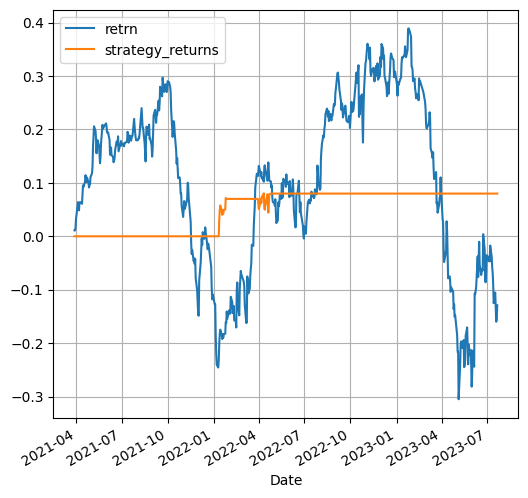

In [28]:
# plotting strategy historical performance over time
df[['retrn','strategy_returns']] = data[['retrn','strategy_returns']].cumsum()
df[['retrn','strategy_returns']].plot(grid=True, figsize=(6, 6))


In [29]:
# try:
#   import mplfinance as mpl
# except ImportError:
#   !pip install -q  mplfinance
#   import mplfinance as mpl

# dados = data['2022':].copy()

# plot_bbol_m = mpl.make_addplot(dados['bb_m'])
# plot_bbol_h = mpl.make_addplot(dados['h_bb'])
# plot_bbol_l = mpl.make_addplot(dados['l_bb'])
# plot_bbol_atr = mpl.make_addplot(dados['atr'],panel=1, ylabel='ATR(20)')


# mpl.plot(dados,type='candle',style="charles",figsize=(14,5), addplot=[plot_bbol_m,plot_bbol_h,plot_bbol_l,plot_bbol_atr])#,volume=True)

In [30]:
# ## substitui pela biblioteca ta

# def tr(df, n=20):
#   dd = df.copy()
#   dd['high_low']   = dd['High'] - dd['Low']
#   dd['high_close'] = np.abs(dd['High'] - dd['Close'].shift(1))
#   dd['low_close']  = np.abs(dd['Low'] - dd['Close'].shift(1))
#   dd['tr']  = dd[['high_low', 'high_close', 'low_close']].max(axis=1)

#   sma = dd['tr'].rolling(window=n, min_periods=n).mean()[:n]
#   dd['tr'] = pd.concat([sma , dd['tr'][n:]]).ewm(alpha=1/n, adjust=False).mean()

#   return dd['tr']

# def bollinger_bands(df,n=20,dp=2):
#   dd = pd.DataFrame(df['Close'])
#   dd['stdev'] = dd['Close'].rolling(window=n).std()
#   dd['sma']   = dd['Close'].rolling(window=n).mean()
#   dd['upbb']  = dd['sma']+dp*dd['stdev']
#   dd['lobb']  = dd['sma']-dp*dd['stdev']

#   return dd[['lobb' , 'sma' , 'upbb' ]]

# dt = pd.DataFrame({
#   "Array_1": [49,0, 70 ,0,0,0,0,0,1,1,1,1,0,0,0,0,-1,-1,-1,-1,-1],
# })

# print(dt.replace(to_replace=0, method='ffill') )#.replace(49.50, 60))